In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from environment import Environment
from actor_model import Actor
from copy import deepcopy

In [4]:
n_samples = 1
n_locations = 5
max_demand = 10
max_capacity = 50

actor = Actor(n_locations)
optimizer = tf.keras.optimizers.legacy.Adam()

env_org = Environment(n_samples, n_locations, max_demand, max_capacity)

In [5]:
grads_lst = []
losses = []
for _ in range(100):
    env = deepcopy(env_org)
    with tf.GradientTape(persistent=True) as tape:
        actions = []
        for _ in range(10):
            logits = actor(env, training=True) - env.mask * 1000

            logits_max = tf.nn.softmax(logits * 100)

            action = tf.reduce_mean(env.locations * tf.tile(tf.expand_dims(logits_max, -1), [1, 1, 2]), axis=1)

            env.update(tf.argmax(logits, 1))

            actions.append(action)

        acts = tf.convert_to_tensor(actions)  # shape [n_steps x n_samples x 2]
        acts_shifted = tf.concat((tf.expand_dims(actions[-1], 0), actions[:-1]), 0)

        # distances = tf.math.sqrt(tf.reduce_sum(tf.math.square(acts_shifted - acts), -1) + 1e-12)
        distances = tf.reduce_sum(tf.math.square(acts_shifted - acts), -1)

        summed_path = tf.reduce_sum(distances, axis=0)

        loss = tf.reduce_mean(summed_path)
        losses.append(loss)
        print(loss)
    
    grads = tape.gradient(loss, actor.trainable_variables)
    grads_and_vars = zip(grads, actor.trainable_variables)
    optimizer.apply_gradients(grads_and_vars)
    grads_lst.append(grads)

tf.Tensor(15.729216, shape=(), dtype=float32)
tf.Tensor(6.2762303, shape=(), dtype=float32)
tf.Tensor(12.943418, shape=(), dtype=float32)
tf.Tensor(6.0691986, shape=(), dtype=float32)
tf.Tensor(5.966263, shape=(), dtype=float32)
tf.Tensor(12.60173, shape=(), dtype=float32)
tf.Tensor(12.428734, shape=(), dtype=float32)
tf.Tensor(5.5183806, shape=(), dtype=float32)
tf.Tensor(5.3460984, shape=(), dtype=float32)
tf.Tensor(11.8763075, shape=(), dtype=float32)
tf.Tensor(10.606827, shape=(), dtype=float32)
tf.Tensor(11.846489, shape=(), dtype=float32)
tf.Tensor(12.651161, shape=(), dtype=float32)
tf.Tensor(12.870171, shape=(), dtype=float32)
tf.Tensor(12.749937, shape=(), dtype=float32)
tf.Tensor(5.01282, shape=(), dtype=float32)
tf.Tensor(4.989591, shape=(), dtype=float32)
tf.Tensor(4.711831, shape=(), dtype=float32)
tf.Tensor(11.3526745, shape=(), dtype=float32)
tf.Tensor(13.243626, shape=(), dtype=float32)
tf.Tensor(14.159781, shape=(), dtype=float32)
tf.Tensor(4.6467805, shape=(), dtype=f

KeyboardInterrupt: 

In [9]:
actor(env, training=True)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[-0.02098108, -0.0214009 ,  0.17721322, -0.02051025, -0.02129656]],
      dtype=float32)>

In [11]:
logits_max

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=array([[1., 0., 0., 0., 0.]], dtype=float32)>

In [7]:
logits.shape

TensorShape([100, 5])

In [8]:
tf.argmax(logits, 1).shape

TensorShape([100])

In [70]:
grads_lst[2]

[<tf.Tensor: shape=(18, 1024), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1024,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(1024, 1024), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1024,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(1024, 1024), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..

In [49]:
grads_lst[-1]

[<tf.Tensor: shape=(18, 1024), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1024,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(1024, 1024), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1024,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(1024, 1024), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..

In [40]:
logits_max

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

In [38]:
summed_path

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>

In [39]:
grads

[<tf.Tensor: shape=(18, 1024), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1024,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(1024, 1024), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1024,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(1024, 1024), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..

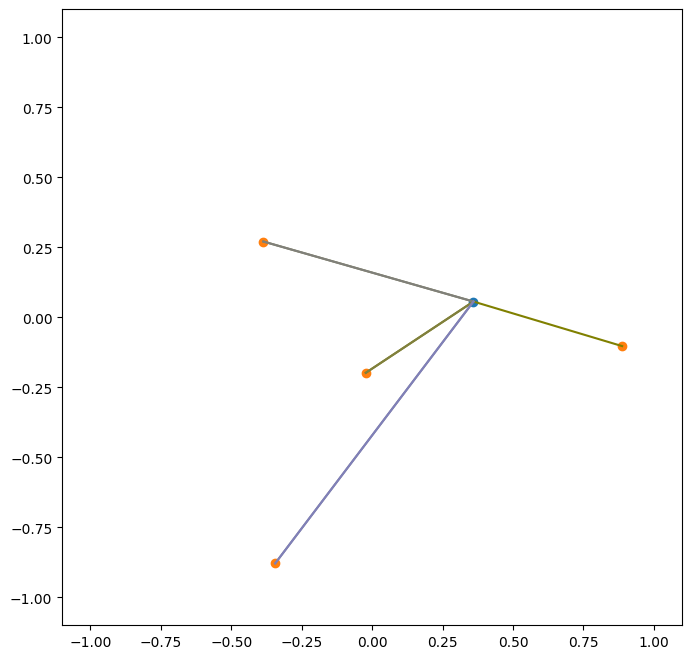

In [21]:
 plt.figure(figsize=(8, 8))

sample_id = 0

plt.scatter(env.locations[sample_id, 0, 0], env.locations[sample_id, 0, 1])
plt.scatter(env.locations[sample_id, 1:, 0], env.locations[sample_id, 1:, 1])
for i in range(len(acts) - 1):
    plt.plot(
        [acts[i, sample_id, 0], acts[i + 1, sample_id, 0]],
        [acts[i, sample_id, 1], acts[i + 1, sample_id, 1]],
        c=(0.5, 0.5, 0.12 * i)
    )
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])
plt.show()

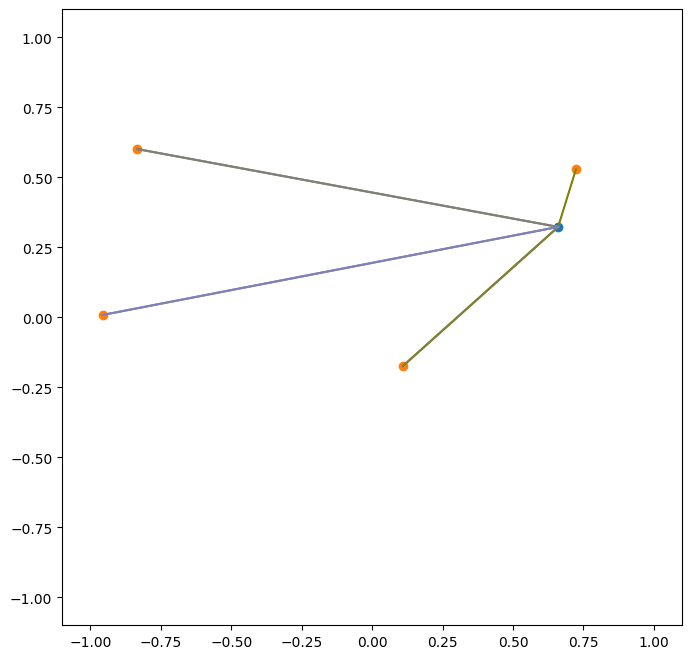

In [218]:
plt.figure(figsize=(8, 8))

sample_id = 0

plt.scatter(env.locations[sample_id, 0, 0], env.locations[sample_id, 0, 1])
plt.scatter(env.locations[sample_id, 1:, 0], env.locations[sample_id, 1:, 1])
for i in range(len(acts) - 1):
    plt.plot(
        [acts[i, sample_id, 0], acts[i + 1, sample_id, 0]],
        [acts[i, sample_id, 1], acts[i + 1, sample_id, 1]],
        c=(0.5, 0.5, 0.12 * i)
    )
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])
plt.show()

In [199]:
env.locations

<tf.Tensor: shape=(1, 5, 2), dtype=float32, numpy=
array([[[ 0.07212067, -0.7051022 ],
        [ 0.6448593 ,  0.961267  ],
        [ 0.32438517, -0.9069562 ],
        [ 0.6313579 ,  0.18848944],
        [ 0.29225063,  0.23455405]]], dtype=float32)>

In [189]:
env.demands

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=array([[0., 0., 0., 0., 0.]], dtype=float32)>